In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import bayesian_pdes as bpdes

In [5]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video autoplay loop controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
animation.Animation._repr_html_ = anim_to_html

In [6]:
x, y, alpha, ls, dt = sp.symbols('x,y,alpha,ls,dt')
def L(k):
    return k + alpha*dt*k.diff(x,x)
def Lbar(k):
    return k + alpha*dt*k.diff(y,y)
def B(k):
    return k
def Bbar(k):
    return k
def neumann(k):
    return k.diff(x)
def neumann_bar(k):
    return k.diff(y)

k = sp.exp(-(x-y)**2 / (2.*ls**2))
op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [L, B, neumann],
    [Lbar, Bbar, neumann_bar],
    k,
    [[x], [y], [alpha, ls, dt]]
)

In [7]:
dt = 0.0001
Tend = 0.3
dx = 0.01
Len = 1.
x_pts = np.arange(0,Len+dx,dx)[:,None]
x_int = x_pts[1:-1]
x_bdy = x_pts[[0, -1]]
times = np.arange(0,Tend+dt,dt)

In [8]:
def u0(x_pts):
    #return np.exp(np.random.normal(np.log(0.5), 0.1, x_pts.shape))
    #return 1-4*(x_pts-0.5)**2
    return 1./(1+np.exp(-20*(x_pts-0.5)))

In [9]:
alpha_val = 1.0
length_scale = 2*dx
base_args = np.array([alpha_val, length_scale])

In [10]:
np.random.seed(0)
ics = [(x_pts, u0(x_pts))]
fa = np.array([alpha_val, length_scale, 0.01])

In [11]:
initial_posterior = bpdes.collocate([()], [()], ics, op_system, fa)
operated = initial_posterior.apply_operators([L], [Lbar])

In [12]:
def solve_euler(initial_obs, times, other_args):
    # assumption: times equally spaced
    dt = times[1]-times[0]
    # convention: last args are [dt, theta]
    fun_args = np.append(other_args, [dt])
    print fun_args
    
    initial_posterior = bpdes.collocate([()], [()], initial_obs, op_system, fun_args)
    cur_posterior = initial_posterior
    posteriors = [cur_posterior]
    for t in times[1:]:
        # first compute the observations
        operated_int = cur_posterior.apply_operators([L], [Lbar])
        test = x_pts
        mu_op, Sigma_op = operated_int(test)
        obs = [
            (test, mu_op, Sigma_op),
            (x_bdy, np.array([[0.], [0.]]))
        ]
        
        cur_posterior = bpdes.collocate([(), neumann], [(), neumann_bar], obs, op_system, fun_args)
        posteriors.append(cur_posterior)
    return posteriors

In [13]:
def A(k):
    return k.diff(x,x)
def A_bar(k):
    return k.diff(y,y)
op_system_basic = bpdes.operator_compilation.sympy_gram.compile_sympy([A, neumann], [A_bar, neumann_bar], k, [[x], [y], [alpha, ls]])

In [14]:
op_system_basic[(A, A_bar)]

<function tmphAQgjL.nxaoqwyi_gram>

In [15]:
from bayesian_pdes.util import linalg

In [37]:
left_A = bpdes.collocation.compute_operator_matrix([A], [(), neumann_bar], [x_pts], [x_pts, x_bdy], op_system_basic, base_args)
right_A = bpdes.collocation.compute_operator_matrix([(), neumann], [A_bar], [x_pts, x_bdy], [x_pts], op_system_basic, base_args)
interior = bpdes.collocation.compute_operator_matrix([(), neumann], [(), neumann_bar], [x_pts, x_bdy], [x_pts, x_bdy], op_system_basic, base_args)
left = bpdes.collocation.compute_operator_matrix([()], [(), neumann_bar], [x_pts], [x_pts, x_bdy], op_system_basic, base_args)
right = bpdes.collocation.compute_operator_matrix([(), neumann], [()], [x_pts, x_bdy], [x_pts], op_system_basic, base_args)
k_mat = bpdes.collocation.compute_operator_matrix([()], [()], [x_pts], [x_pts], op_system_basic, base_args)
A_k = bpdes.collocation.compute_operator_matrix([A], [A_bar], [x_pts], [x_pts], op_system_basic, base_args)


cur_llbar_inv = np.linalg.inv(k_mat)
cur_mu = u0(x_pts)
Sigma = k_mat - k_mat

mus = [cur_mu]
Sigmas = [Sigma]

left_multiplier = bpdes.collocation.compute_operator_matrix([A], [()], [x_pts], [x_pts], op_system_basic, base_args)
right_multiplier = bpdes.collocation.compute_operator_matrix([()], [A_bar], [x_pts], [x_pts], op_system_basic, base_args)
mult_A = np.dot(left_multiplier, cur_llbar_inv)
mu_A = np.dot(mult_A, u0(x_pts))
Sigma_A = A_k - np.dot(mult_A, right_multiplier)

err_mat = k_mat - np.dot(np.dot(dt*left_multiplier, cur_llbar_inv), k_mat)\
                - np.dot(np.dot(k_mat, cur_llbar_inv), dt*right_multiplier)\
                - np.dot(np.dot(dt*left_multiplier, ))

mu_As = [mu_A]
Sigma_As = [Sigma_A]

for t in times[1:]:
    # first apply operators to A
    #mu_mult_A = np.dot(left_A, cur_llbar_inv)
    #mu_A = np.dot(mu_mult_A, mu_A)
    #Sigma_A = A_k - np.dot(mu_mult_A, right_A)
    
    obs = np.append(cur_mu + dt*mu_A, [[0], [0]])
    cur_llbar_inv = np.linalg.inv(interior + linalg.block_diag([err_mat, np.zeros((2,2))]))
    cur_mu_mult = np.dot(left, cur_llbar_inv)
    cur_mu = np.dot(cur_mu_mult, obs)
    cur_Sigma = k_mat - np.dot(cur_mu_mult, right_A)

    mus.append(cur_mu)
    Sigmas.append(cur_Sigma)
    
    mu_mult_A = np.dot(left_A, cur_llbar_inv)
    mu_A = np.dot(mu_mult_A, obs)
    Sigma_A = A_k - np.dot(mu_mult_A, right_A)
    
    err_mat = A_k - np.dot(np.dot(left + dt*left_A, cur_llbar_inv), right + dt*right_A)
    
    mu_As.append(mu_A)
    Sigma_As.append(Sigma_A)

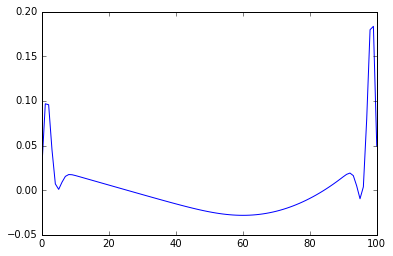

In [50]:
plt.plot(mu_As[1])

In [ ]:
dt

In [ ]:
plt.plot(x_pts, mus[2])

In [56]:
posteriors_euler = solve_euler(ics, times, base_args)

[  1.00000000e+00   2.00000000e-02   1.00000000e-04]


In [57]:
p = posteriors_euler[1]

In [58]:
def plot_parabolic_1d(test_points, posteriors, times, stride=1):

    means, covs = [], []
    for p,time in zip(posteriors[::stride], times[::stride]):
        #print time
        mu, cov = p(test_points)
        means.append(mu)
        covs.append(cov)
    means = np.column_stack(means)
    
    fig = plt.gcf()
    ax = plt.gca()
    line, = ax.plot([], [])
    ub, = ax.plot([], [], linestyle='--', c='black')
    lb, = ax.plot([], [], linestyle='--', c='black')
    # initialization function: plot the background of each frame
    def init():
        return []

    # animation function.  This is called sequentially
    def animate(i):
        cov = covs[i]
        mean = means[:,i]
        line.set_data(test_points, mean)
        ub.set_data(test_points, mean+np.diag(cov))
        lb.set_data(test_points, mean-np.diag(cov))
        ax.set_title('t={}'.format(times[i]))
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=means.shape[1], interval=20, blit=False)
    plt.close()
    return anim

In [59]:
test_points = np.linspace(0,Len, 51)[:,None]
plt.xlim(x_pts.min(), x_pts.max())
plt.ylim(0,1.)
plot_parabolic_1d(test_points, posteriors_euler, times, stride=10)